# Appendix

## 0) Setup
#### Import Python Libraries to explore and visualise data

In [1]:
import os
###### for data manipulation #####
import pandas as pd
import numpy as np
import datetime
from scipy.stats import pearsonr
##### for data visualisation #####
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import seaborn as sns
plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
##### colour code for visualisations #####
penney_red = '#D91920'
#### set figure font ####
plt.rcParams["font.family"] = "serif"

### JCPenney Data:
There are 5 files given:
`products.csv`, `users.csv`, `reviews.csv`,
`jcpenney_reviewers.json`, `jcpenney_products.json`

Let's **import** the data and understand what information we have!

In [3]:
# filepath to folder containing JCPenney data 
directory = "C:/Users/Darragh/Desktop/RMData/jcpenney"   #change if necessary

# list of file names in JCPenney folder to load in`
files = ['products.csv', 'users.csv', 'reviews.csv',
         'jcpenney_reviewers.json','jcpenney_products.json']

Load in JCPenney data (using `read_csv()` and `read_json()`) into a dataframe (df).
Then store in a dictonary for easy access later. 

In [4]:
# initialise dictionary
jcpenney_dfs = {} 

for file_name in files:  
    path = os.path.join(directory, file_name) # Store path to file 
    
    # Load .csv file as df and add to dictionary (key = file_name)
    if file_name.endswith('.csv'):      
         jcpenney_dfs[file_name] = pd.read_csv(path) 

    #^same as before but for .json files
    elif file_name.endswith('.json'):    
        jcpenney_dfs[file_name] = pd.read_json(path, lines = True)   
                #each line in .json file is a json object^^
        
# check files have been added correctly
print(f'jcpenney_dfs = {list(jcpenney_dfs)}')

jcpenney_dfs = ['products.csv', 'users.csv', 'reviews.csv', 'jcpenney_reviewers.json', 'jcpenney_products.json']



####  We can access any file's df using the following:  `df = jcpenney_dfs[file_name]`

---------------------------------------

# 1) Explore the data

In [5]:
# Check number of row/columns and column names in each file
for file_name, df in jcpenney_dfs.items():
    rows, cols = df.shape
    column_names = ', '.join(df.columns)
    
    print(f"\n{file_name} -- {rows} rows and {cols} columns")
    print(f"Columns: {column_names}")


products.csv -- 7982 rows and 6 columns
Columns: Uniq_id, SKU, Name, Description, Price, Av_Score

users.csv -- 5000 rows and 3 columns
Columns: Username, DOB, State

reviews.csv -- 39063 rows and 4 columns
Columns: Uniq_id, Username, Score, Review

jcpenney_reviewers.json -- 5000 rows and 4 columns
Columns: Username, DOB, State, Reviewed

jcpenney_products.json -- 7982 rows and 15 columns
Columns: uniq_id, sku, name_title, description, list_price, sale_price, category, category_tree, average_product_rating, product_url, product_image_urls, brand, total_number_reviews, Reviews, Bought With


## First let's explore data relating to JCPenney customers age and review scores

In [6]:
#Load in jcpenney_products.json + users.csv  dfs
df = jcpenney_dfs['jcpenney_products.json'].copy()
df_user = jcpenney_dfs['users.csv'].copy()

#Review column in jcpenney_products.json contains list of dictonaries of Username, Review and Score
#Convert nested dictonary to df, save as df_score

df_score = pd.json_normalize(    #.explode() creates new row for each item in Review column
    df['Reviews'].explode() )    # .json_normalize() flattens them horizontally into `score_df`

#show
display(df_score.head(1))
display(df_user.head(1))

,User,Review,Score
0,fsdv4141,You never have to worry about the fit...Alfred...,2


,Username,DOB,State
0,bkpn1412,31.07.1983,Oregon


In [7]:
# Convert df_score data types: User -> str
df_score['User'] = df_score['User'].astype('string')

# Convert user.csv data types: Username -> str //   DOB -> datetime 
df_user['Username'] = df_user['Username'].astype('string')
df_user['DOB'] = pd.to_datetime(df_user['DOB'])

#rename column username -> user to join df_score with df_user
df_user = df_user.rename(columns ={'Username':'User'})

In [8]:
#create new age column from DOB
today = datetime.date.today()
df_user['Age'] = ((today - df_user['DOB'].dt.date) / pd.Timedelta(days=365.25)
    ).round().astype(int)                             #^account for leap years

#### Next, we will categories user's age into Age Categories 18-24, 25-34, 35-44, 45-54, 55-64, 65+

In [9]:
#Create bins and labels for age categories
bins = [18,25,35,45,55,65,80]
age_cat = ['18-24','25-34','35-44','45-54','55-64','65+']

#creating age category column from 'Age' column, using pd.cut()
#right=false to ensure boundary ages e.g. 25 are include in correct 25-34 bin
df_user['Age_Category'] = pd.cut(df_user['Age'],  
                            bins=bins,
                            labels=age_cat, 
                            right=False) 

#ensure categories are ordered for sorting and plotting
df_user['Age_Category'] = df_user['Age_Category'].astype(
    pd.CategoricalDtype(categories=age_cat, ordered=True))

In [10]:
# inner join on 'user' between df_user and df_score, 
# return new df called `df_userscore`
df_userscore = pd.merge(df_user, df_score, on='User', how = 'inner')

print(df_userscore.info())
#display(df_userscore.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39080 entries, 0 to 39079
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   User          39080 non-null  string        
 1   DOB           39080 non-null  datetime64[ns]
 2   State         39080 non-null  object        
 3   Age           39080 non-null  int64         
 4   Age_Category  39080 non-null  category      
 5   Review        39080 non-null  object        
 6   Score         39080 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(2), string(1)
memory usage: 1.8+ MB
None


#### `df_userscore` contains all 39080 review scores + user information (age, age_category etc.)

# Figure 1
Histogram with a Kernel Density Estimate (KDE) Curve showing JCPenney Customer ages

- KDE curve will provide an easy visual of age distribution, including any peaks in certain age brackets.
- Alternatives considered were a pie chart but this felt inferior as it's difficult to compare age categories like a histogram. 

In [11]:
#Filter `df_userscore` for 'user', 'age' + 'age_category'
plot_age = df_userscore[['User','Age','Age_Category']]

#drop duplicates
plot_age = plot_age.drop_duplicates()
print(f'Rows after dropping dups: {len(plot_age)}')

Rows after dropping dups: 4994


In [12]:
#check if any users appear more than once
plot_age['User'].value_counts().head(2)

User
dqft3311    2
czof3441    1
Name: count, dtype: Int64

USER dqft3311 appears more than 1 with different DOB, we will remove this user from further analysis

In [13]:
#update df to remove user 'dqft3311'
plot_age = plot_age[plot_age['User']!= 'dqft3311']

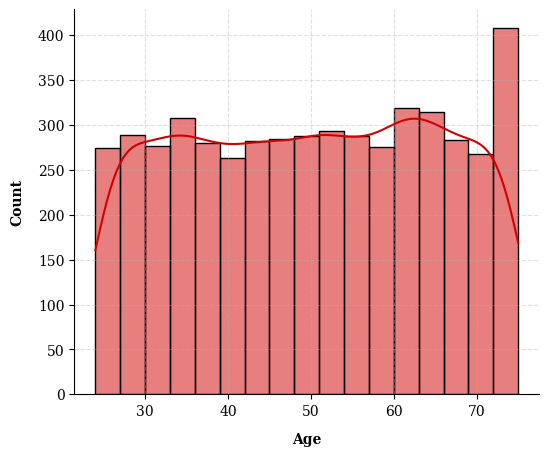

In [14]:
#figure specs
plt.figure(figsize = (6,5))#, dpi = 300)

#plotting and coloring graph data
#assign to 'ax' to change figure layout (below)
ax = sns.histplot(x=plot_age['Age'],
        bins = 'auto',
        kde = True,
        color = '#D20001',
        edgecolor='black')

#remove right and top axes borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#axis labels + spacing, grid settings
plt.xlabel('Age', fontweight = 'bold', labelpad = 10)
plt.ylabel('Count', fontweight = 'bold', labelpad = 10)
plt.grid(linestyle = '--', alpha = 0.4)

#plt.savefig('Hist_of_age.png', transparent = True)
plt.show()

# Figure 2
Heatmap for % of scores given by an age category (normalised percentage calculated by dividing total times a score was given by total category population x 100)

- Provides a visually pleasing snap shot to compare how each age category scores JCPenney products 
- Alternative visuals considered were stacked bar chart however elected to choose heatmap for a business report as colour change indicates difference in % of scores given rather than purely a difference between age category  

In [15]:
#use .crosstab() to calculate total number of each score given 
#by age category
rating_by = pd.crosstab(index=df_userscore['Age_Category'],
                        columns=df_userscore['Score'])
display(rating_by)

Score,1,2,3,4,5
Age_Category,,,,,
18-24,132,123,124,111,122
25-34,1542,1545,1549,1492,1447
35-44,1426,1475,1413,1453,1495
45-54,1579,1443,1521,1407,1520
55-64,1543,1556,1608,1540,1547
65+,1715,1625,1678,1680,1669


In [16]:
#Sum the total across rows horizontally (hence axis=1)
row_sums = rating_by.sum(axis=1)
#divide value in cell by row_sums total from previous and x100 for %
rating_by_norm = rating_by.div(row_sums, axis=0) * 100

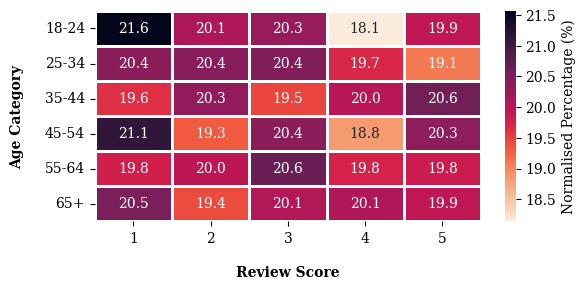

In [17]:
#Figure specs
plt.figure(figsize=(6, 3))#, dpi = 300)

#plotting data and coloring heatmap
sns.heatmap(
    rating_by_norm,
    annot=True,
    fmt=".1f",           
    cmap="rocket_r",       
    linewidths=1,
    cbar_kws={'label': 'Normalised Percentage (%)'}
)

#axis labels and spacing
plt.xlabel('Review Score', fontweight = 'bold',labelpad = 15)
plt.ylabel('Age Category', fontweight = 'bold',labelpad = 15)
plt.tight_layout()

#plt.savefig('review_score_heatmap.png', transparent = True)
plt.show()

## Next, Lets check total and average score reviews for all JC Penney products

In [18]:
# get jcpenney_products.json df
df= jcpenney_dfs['jcpenney_products.json'].copy()

#show first 2 rows
display(df.head(2))

,uniq_id,sku,name_title,description,list_price,sale_price,category,category_tree,average_product_rating,product_url,product_image_urls,brand,total_number_reviews,Reviews,Bought With
0,b6c0b6bea69c722939585baeac73c13d,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,alfred dunner,jcpenney|women|alfred dunner,2.625,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'fsdv4141', 'Review': 'You never hav...","[898e42fe937a33e8ce5e900ca7a4d924, 8c02c262567..."
1,93e5272c51d8cce02597e3ce67b7ad0a,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,You'll return to our Alfred Dunner pull-on cap...,41.09,24.16,alfred dunner,jcpenney|women|alfred dunner,3.000,http://www.jcpenney.com/alfred-dunner-essentia...,http://s7d9.scene7.com/is/image/JCPenney/DP122...,Alfred Dunner,8,"[{'User': 'tpcu2211', 'Review': 'You never hav...","[bc9ab3406dcaa84a123b9da862e6367d, 18eb69e8fc2..."


#### We see multiple rows for the same `product`, therefore we need to collate data so each product has it's own row.

#### We first filter for the columns needed:
- `sku` (Stock Keeping Unit) - Unique identifier for products
-  `average_product_rating`
-  `total_number_reviews`.


<br>

#### And clean up data (e.g. remove rows with empty sku's, and keep plausible results (rating 1-5))

In [19]:
# filter columns
df = df[['sku','average_product_rating','total_number_reviews']]
print(f'Starting rows: {len(df)}')

# remove rows with empty sku entries
df = df[ df['sku'] != '']
print(f'Remove empty sku entries, rows left: {len(df)}')

#keep ratings 1-5 only
df = df[df['average_product_rating'].between(1,5)]
print(f'Keep ratings between 1-5, rows left: {len(df)}')

Starting rows: 7982
Remove empty sku entries, rows left: 7915
Keep ratings between 1-5, rows left: 7915


#### <a id="agg"></a> Next we group rows by `sku` (using `.groupby`) and calculate the true `average_product_rating` and `total_number_reviews` for each product (using `.agg()`).




In [20]:
##.agg(new_column_name =('prev_column_name', 'calculation_peformed') 
# return as new df, `df_sku_stats`
df_sku_stats = df.groupby('sku').agg(
    average_product_rating = ('average_product_rating','mean'), 
    total_number_reviews = ('total_number_reviews', 'sum'))    

#reset index so sku can be accessed for queries
df_sku_stats = df_sku_stats.reset_index()

#show df head
display(df_sku_stats.head(2))

,sku,average_product_rating,total_number_reviews
0,0903a80,2.9375,16
1,13cab12,2.8750,16


In [21]:
#check each row if sku are unique
sku_unique = df_sku_stats['sku'].nunique() == len(df_sku_stats)
print(sku_unique)

True


#### `df_sku_stats` contains product `sku` with their respective `average_product_rating` and `total_number_review`.

-------------------------------
## Looking at brand insights

While JCPenney does offer products from a variety of brands seen in other stores (e.g. Nike), they have their own private brands/labels that are sold exclusively in JCPenney stores. 

- Let's take a look at how JCPenney private brands compare to other brands..



##### *Sourced JCPenney Private Brands from (https://trademarks.justia.com/owners/j-c-penney-private-brands-inc-7136)*

In [22]:
#list of jcpenney private brands
jcp_private_brands = [
    "St. John's Bay", "Arizona",
    "Xersion", "Worthington", 
    "a.n.a", "Ambrielle", "Liz Claiborne", 
    "Stafford", "JF J.Ferrar", "Collection", 
    "The Foundry Supply Co.", "Okie Dokie",
    "JCP Home", "JCP Home Collection",
    "Studio by jcp home", "Cooks",
    "Home Expressions", "North Pole Trading Co",
    "Modern Bride"]

#convert list items to lowercase 
#for easier merging/checking with other dataset
jcp_private_brands = [i.lower() for i in jcp_private_brands]

In [23]:
#load `jcpenney_products.json` df
df = jcpenney_dfs['jcpenney_products.json'].copy()

#filter columns
df = df[['sku','brand']]

#convert column datatype, 'sku' and 'brand' --> str
df['sku'] = df['sku'].astype('string')
df['brand'] = df['brand'].astype('string')

#convert brands to lowercase for ease when merging together
#in the case same brands are spelt with/without capitals
df['brand'] = df['brand'].str.lower()

#### Clean up df by removing rows with empty `sku` entries + removing duplicate rows with same `sku` and `brand`

In [24]:
#show starting no. rows in df
print(f'Starting rows = {len(df)}')

#drop empty sku rows
df = df[ df['sku'] != '']
print(f'Removing empty sku entries, Rows = {len(df)}')

#drop rows with same sku and same brand
df = df.drop_duplicates()
print(f'Removing duplicate entries, Rows = {len(df)}')

Starting rows = 7982
Removing empty sku entries, Rows = 7915
Removing duplicate entries, Rows = 6045


In [25]:
# Check if the number of unique SKUs equals the total number of rows
# i.e. are all sku associated with only 1 brand?
sku_unique = df['sku'].nunique() == len(df)
print(sku_unique)

False


Since result is FALSE, we need to check which sku are associated with multiple brands and correct it appropriately 

In [26]:
#group by sku and filter for sku's with >1 brand associated
find_sku = df.groupby('sku')['brand'].nunique()
dup_brand = find_sku[find_sku>1].index

#return df (dup_df) to check position of multi-brand associated skus
dup_df = df[ df['sku'].isin(dup_brand)].copy()
dup_df.head()


,sku,brand
522,pp5005280084,jcp home
7648,pp5002940877,studio by jcp home
7731,pp5002940877,studio
7739,pp5005280084,jcp home collection


#### `sku` pp5002940877 + pp5005280084 are associated with multiple brands, however seems to be different wordings for a similar brand
- Let's check which brand wording appears most frequently and remove the least frequent occurrence.

In [27]:
#Finding freq of all brands 
all_brands = df['brand'].value_counts()

# get brands which appear with multiple sku (dup_df)
# and find how often they occur 
conflict_brands = dup_df['brand'].unique()
freq = all_brands.loc[conflict_brands]

print(freq.sort_values(ascending=False))

brand
jcp home               102
studio by jcp home       8
jcp home collection      3
studio                   2
Name: count, dtype: Int64


Appears `studio`, `jcp home collection` are the least frequent occurring, therefore we will remove these version of the sku

In [28]:
#Let's remove entries by their index (7731 + 7739)
print(len(df))
df.drop(labels=[7731,7739], inplace=True)
print(f'{len(df)}, 2 entries successfully removed')

6045
6043, 2 entries successfully removed


In [29]:
# Again, check if unique SKUs are associate with 1 brand only
sku_unique = df['sku'].nunique() == len(df)
print(sku_unique)

True


Now that the result is TRUE, we can continue with the data now each `sku` is associated with a single `brand`

Now we can add in a column to show which brands are JCPenney exclusives!

In [30]:
# Create new column 'exclusive_to_jcpenney', using .npwhere()
#if brand matches any brand found in list 'jcp_private_brands'
# entry will be 'yes' and 'no' if not.
df['exclusive_to_jcpenney'] = np.where(
    df['brand'].isin(jcp_private_brands),
                            'yes',
                            'no')

#Set sku as index and save df as `df_brands` for later
df_brands = df.set_index('sku')

#### `df_brands` contains product `sku` with respective `brand` and whether or not they are `exclusive_to_jcpenney`
---------------------------------------------------------------
#### Merge dfs `df_sku_stats` with `df_brands` to get stats about each brand

In [31]:
#Check number of rows in each df
display(df_sku_stats.head(1))
print(f'df_sku_stats rows: {len(df_sku_stats)}')

display(df_brands.head(1))
print(f'df_brands rows: {len(df_brands)}')

,sku,average_product_rating,total_number_reviews
0,0903a80,2.9375,16


df_sku_stats rows: 6043


,brand,exclusive_to_jcpenney
sku,,
pp5006380337,alfred dunner,no


df_brands rows: 6043


##### Both dfs have same number of rows, let's merge them together!

In [32]:
#Merge dfs using Inner join on the sku
df = pd.merge(df_sku_stats, df_brands, on='sku', how = 'inner')

In [33]:
#check rows after merge 
print(f'Number of rows: {len(df)}')

#save df as df_brand_stats
df_brand_stats = df.copy()
df_brand_stats.head(1)

Number of rows: 6043


,sku,average_product_rating,total_number_reviews,brand,exclusive_to_jcpenney
0,0903a80,2.9375,16,kitchen aid,no


#### Next we group data by brand (using `.groupby()`) to get insights on individual brand performance using `.agg()`, same as before for `df_sku_stats`!

In [34]:
#.agg(new_column_name =('prev_column_name', 'calculation_peformed')
#Then save df as `group_brand_stats' for future recall
group_brand_stats = df_brand_stats.groupby('brand').agg(
    average_rating=('average_product_rating', 'mean'),
    total_reviews=('total_number_reviews', 'sum'),
    number_of_products=('sku', 'count'),
    exclusive_to_jcpenney=('exclusive_to_jcpenney', 'first')
)               #'first' will retain exclusivity status in agg. df  
                # as all brand products are labelled the same

display(group_brand_stats.head(2))
print(f'Number of brands: {len(group_brand_stats)}')

,average_rating,total_reviews,number_of_products,exclusive_to_jcpenney
brand,,,,
1928 jewelry,4.750000,3,2,no
a.n.a,3.056643,1106,126,yes


Number of brands: 711


----------------------------------------------------
### Lets visualise data to see specific brand performance
- Because we don't want brands/products with low numbers of reviews skewing results, we should filter to **only include brands with >5 reviews.**

In [35]:
#Filter for 'total_reviews' >=5, save as plot_brand for later recall
plot_brand = group_brand_stats[group_brand_stats['total_reviews']>=5]

#confirming number of removed rows
print(f'''{len(group_brand_stats)-len(plot_brand)} brands have less than 5 reviews.
Brands remaining: {len(plot_brand)}''')

#show 2 rows plot_brand df
display(plot_brand.head(2))

234 brands have less than 5 reviews.
Brands remaining: 477


,average_rating,total_reviews,number_of_products,exclusive_to_jcpenney
brand,,,,
a.n.a,3.056643,1106,126,yes
a2 by aerosoles,3.209722,118,15,no


# Figure 3
#### TOP 25 BRANDS by BY TOTAL NUMBER OF REVIEWS
- Horizontal Barplot seems most reasonable visual as brand names will be very readable on y-axis (rather than vertical barplots x-axis with rotation) + easier to follow annotated number of total reviews along the bar

In [36]:
#sort plot_brand df by highest'average_rating' and take top 25 results
top_25_brands = plot_brand.sort_values(by = 'total_reviews', ascending = False).head(25)

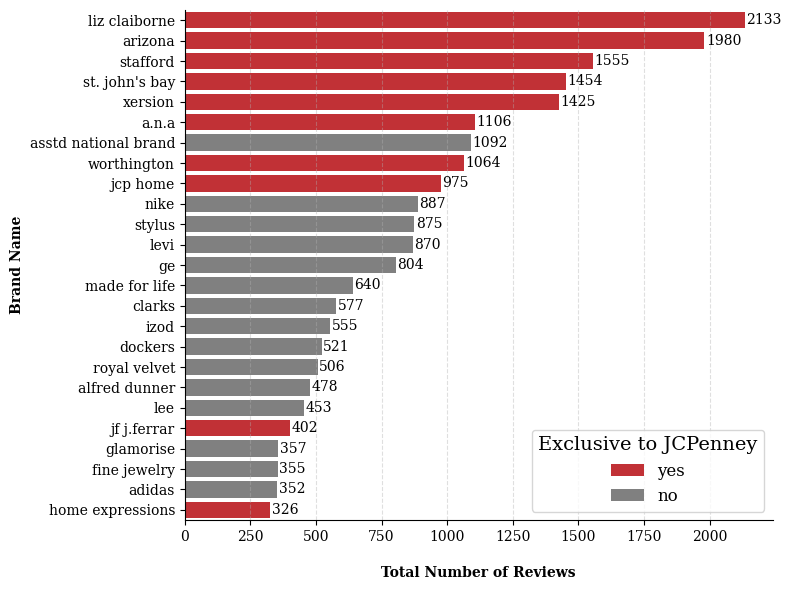

In [37]:
#figure specifications
plt.figure(figsize = (8,6))#, dpi = 300)

#plotting and coloring graph data
#assign to 'ax' to change figure layout (below)
ax = sns.barplot(
    data=top_25_brands,
    x='total_reviews',
    y='brand',
    hue = 'exclusive_to_jcpenney',  #color by exclusivity
    palette= (penney_red, 'grey')
)

#set legend title and fontsize
ax.legend(fontsize=12, title_fontsize=14,
    title = "Exclusive to JCPenney")

#remove right and top axes borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#annoate bars with corresponding value
for bar in ax.containers:
    ax.bar_label(bar, color = 'black', padding=1)

#set axis labels and grid layout
ax.set_xlabel('Total Number of Reviews', fontweight = 'bold', labelpad = 16)
ax.set_ylabel('Brand Name', fontweight = 'bold')         #^^space between label and axis
plt.grid(True, axis = 'x',linestyle='--', alpha = 0.4)
plt.tight_layout()

#plt.savefig('TOP25_BRANDS.png', transparent = True)
plt.show()

# Figure 4
 - Average rating of JCPenney Exclusive Brands
 - Chose Horizontal barplot to read y-axis brand names easily (rather than Vertical barplot and rotating axis labels), and coloured bars can easily distinguish which brands perform above and below brand rating average

In [38]:
#calculate average brand rating for all brands
mean_rating = plot_brand['average_rating'].mean()

#Filter plot_brand by JCPenney exclusives only and sort by
#'average_rating', save as 'top_jcp_brands'
top_jcp_brands = plot_brand[plot_brand['exclusive_to_jcpenney'] == 'yes']
top_jcp_brands = top_jcp_brands.sort_values(by = 'average_rating', ascending = False)

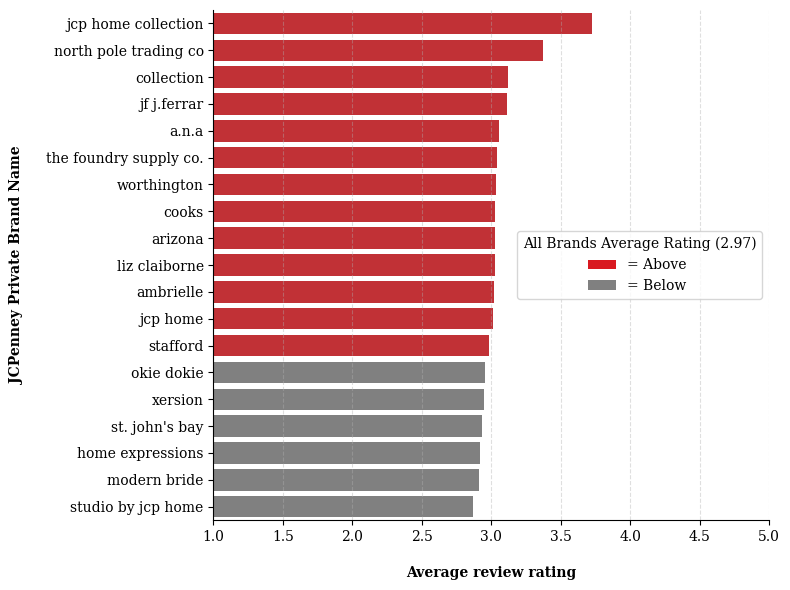

In [39]:
#Need colour palette for graph, use list comphrension to assign
# if above or below mean rating for all brands
bar_colours = [penney_red if rating > mean_rating else 'grey'
              for rating in top_jcp_brands['average_rating']]

#figure specs
plt.figure(figsize=(8, 6))# ,dpi = 300)

#plotting and coloring graph data
#assign to 'ax' to change figure layout (below)
ax = sns.barplot(
    data=top_jcp_brands,
    x='average_rating',
    y='brand',
    palette= bar_colours)


#Need Patches to indicate color in figure legend
legend_patches = [
    # Patch 1: Above Mean = red
    Patch(facecolor=penney_red, label='= Above'),
    # Patch 2: Below Mean = grey
    Patch(facecolor='grey', label='= Below ')
]

#Figure legend
ax.legend(
    handles=legend_patches, 
    title='All Brands Average Rating (2.97)', 
    loc='center right'    
)

#remove right and top axes borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Axis labels
ax.set_xlabel('Average review rating', fontweight = 'bold', labelpad = 16)
ax.set_xlim(1, 5)
ax.set_ylabel('JCPenney Private Brand Name', fontweight = 'bold',labelpad = 16)

plt.grid(True, axis = 'x',linestyle='--', alpha = 0.4)
plt.tight_layout()
#plt.savefig('JCPenney_AVrating.png', transparent = True)
plt.show()

## Jcpenney Discount
Let's look at the trends and impact of discounting prpducts, relating back to JCPenney exclusive brands

In [40]:
#Load in jcpenney_products.json
df = jcpenney_dfs['jcpenney_products.json'].copy() #copy() to prevent warnings
#display(df.head(1))

# filter for columns
df = df[['sku','name_title', 'list_price', 'sale_price']]

# convert dtypes of columns
# SKU + Name -> string and list_price + sale_price -> float
df['sku'] = df['sku'].astype('string')
df['name_title'] = df['name_title'].astype('string')
df['list_price'] = pd.to_numeric(df['list_price'], errors = 'coerce')
df['sale_price'] = pd.to_numeric(df['sale_price'], errors = 'coerce')
                                    #^any entry not able to be numeric will be NaN instead

#show datatypes and no. of non-null values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7982 entries, 0 to 7981
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sku         7982 non-null   string 
 1   name_title  7982 non-null   string 
 2   list_price  5816 non-null   float64
 3   sale_price  7719 non-null   float64
dtypes: float64(2), string(2)
memory usage: 249.6 KB


#### Looking at the data, there seems to be alot of NaN values in the `list_price` column, of 7982 entries only 5816 are non-null
#### We will assume in that case the `sale_price` = `list_price` (i.e. no discount)

In [41]:
# fill list_price with sale_price if sale_price is non-null
df['list_price'] = df['list_price'].fillna(df['sale_price'])

## Cleaning data
- Will remove empty `sku` rows, rows containing `NaN` and rows with `price` < 0.
- Also remove true and 'near' duplicate rows based on sku
    - As some skus have multiple entries but since we lack of timestamped prices **we will simply take the first entry of an sku as it's true price**

In [42]:
# check no. rows in df
print(f'Total: {len(df)} rows in df.')

# filter out rows with empty entries for sku
df = df[ df['sku'] != '']
print(f'Remove rows containing empty sku -> {len(df)} rows remaining.')

# filter out rows containing 'NaN' 
df.dropna(subset=['sku', 'name_title', 'list_price', 'sale_price'], inplace=True)
print(f'Remove rows containing "NaN" -> {len(df)} rows remaining.')

# filter out negative values (<0) in 'list_price' and 'sale_price' column
df = df[ (df['list_price'] > 0) & (df['sale_price'] > 0) ]
print(f'Remove rows containing negative prices -> {len(df)} rows remain.')

# filter out true and near duplicate rows for same sku
df = df.drop_duplicates(subset = ['sku'])
print(f'Remove rows contain true/near duplicates -> {len(df)} rows remain.')

Total: 7982 rows in df.
Remove rows containing empty sku -> 7915 rows remaining.
Remove rows containing "NaN" -> 7654 rows remaining.
Remove rows containing negative prices -> 7610 rows remain.
Remove rows contain true/near duplicates -> 5860 rows remain.


In [43]:
#check each sku is only associated with 1 set of prices
sku_unique = df['sku'].nunique() == len(df)
print(sku_unique)

True


## Calculate Discount % 
- Calculate %discount between list and sale price.
- Store under new column 'discount_percentage'

In [44]:
#1) store numerical difference in column 'discount'
#2) calculate %discount, store in new column
df['discount'] = df['list_price'] - df['sale_price'] 
df['discount_percentage'] = ((df['discount'] / df['list_price']) * 100).round(2)

#Save df as df_discount
df_discount = df.copy()

#### Lets merge `df_discount` and  `df_brands` 

In [45]:
#show the df heads and row length
display(df_discount.head(1))
print(f'Rows = {len(df_discount)}')
display(df_brands.head(1))
print(f'Rows = {len(df_brands)}')

,sku,name_title,list_price,sale_price,discount,discount_percentage
0,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,41.09,24.16,16.93,41.2


Rows = 5860


,brand,exclusive_to_jcpenney
sku,,
pp5006380337,alfred dunner,no


Rows = 6043


In [46]:
#We want to keep 5860 entries from df_discount, hence we will complete a left join with df_brands
df_discount_brand= pd.merge(df_discount, df_brands, on = 'sku', how='left')
display(df_discount_brand.head(2))
print(f'Rows = {len(df_discount_brand)}')

,sku,name_title,list_price,sale_price,discount,discount_percentage,brand,exclusive_to_jcpenney
0,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,41.09,24.16,16.93,41.2,alfred dunner,no
1,pp5006790247,Alfred Dunner® Feels Like Spring 3/4 Sleeve Le...,65.27,39.16,26.11,40.0,alfred dunner,no


Rows = 5860


#### `df_discount_brand` contains product price and discount info + exclusivity status

-------------------------------------------
## Visualise Discount Impact

# Figure 5

- A) Boxplot of Discount %, JCPenney private brand vs other offered brands 
- B) Summary table of boxplot statistics (mean, std, min, max etc.)
     - Boxplot is most reasonable visualisation as alternatives like a violin plot lack the easy-to-read demarcation of quartiles that boxplots offer, which will help audiences understanding of data

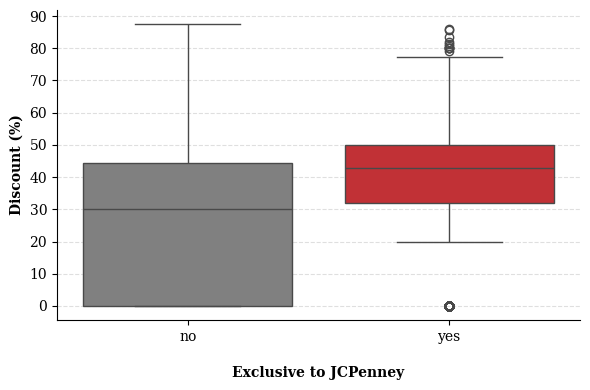

In [47]:
#figure specifications
plt.figure(figsize = (6,4))#, dpi = 300)

#plotting and coloring graph data
#assign to 'ax' to change figure layout (below)
ax = sns.boxplot(
    data=df_discount_brand,
    y='discount_percentage',
    x='exclusive_to_jcpenney',
    #hue = 'exclusive_to_jcpenney',  #color by exclusivity
    palette= ('grey', penney_red)
)

#remove right and top axes borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#set axis labels and grid layout
ax.set_xlabel('Exclusive to JCPenney', fontweight = 'bold', labelpad = 16)
ax.set_ylabel('Discount (%)', fontweight = 'bold')
ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
plt.grid(True, axis = 'y' ,linestyle='--', alpha = 0.4)
plt.tight_layout()

#plt.savefig('Discount_boxplot.png', transparent = True)
plt.show()

# Summary table for figure 5B
To accompany Figure 5A with descriptive stats

In [48]:
#summary table for figure 5B
summary_stats = df_discount_brand.groupby('exclusive_to_jcpenney')['discount_percentage'].describe()
#print(summary_stats)

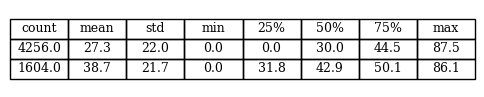

In [49]:
#create a subplot as we need 'ax' for table manipulation
#and 'fig' to finally save figure
fig, ax = plt.subplots(figsize=(6, 1))#, dpi=300) 

# remove border when creating axes 
ax.axis('off') 

#table object
table = ax.table(
    cellText=summary_stats.values.round(1), #take values from summary_stats
    colLabels=summary_stats.columns,     #take column names
    loc='center',             #center table + values in table
    cellLoc='center')

# set table scale and font size
table.set_fontsize(10)
table.scale(1, 1.2) 

#Turn table cells transparent for report
#loop through rows
for i in range(len(summary_stats) + 1):
    # Loop through columns
    for j in range(len(summary_stats.columns)):
        cell = table[(i, j)]  #get posiiton in table
        # Set background colour to 'none' (transparent)
        cell.set_facecolor('none')

#plt.savefig('Boxplot table.png' , transparent = True)
plt.show()

-------------------------------

#### Merging `df_discount` with `df_sku_stats`
- `df_discount` has 5860 entries and `df_sku_stats` has 6043 entries

In [50]:
#We want to keep 5860 entries from df_discount, hence we will complete a left join with df_sku_stats
df_discount_sku = pd.merge(df_discount, df_sku_stats, on = 'sku', how='left')

In [51]:
display(df_discount_sku.head(2))

,sku,name_title,list_price,sale_price,discount,discount_percentage,average_product_rating,total_number_reviews
0,pp5006380337,Alfred Dunner® Essential Pull On Capri Pant,41.09,24.16,16.93,41.2,2.979167,48
1,pp5006790247,Alfred Dunner® Feels Like Spring 3/4 Sleeve Le...,65.27,39.16,26.11,40.0,3.750000,4


# Figure 6
Regression Plot of all products discount % vs. average product rating

- Regression Plot in Seaborn enables the visual aid of the linear regression line on a scatterplot
- Could potentially have used Hexbin plot but as it's not a typical graph used in business reports, therefore elected to use a regression plot which would be more familiar to the JCPenney board 

In [52]:
#Filter data for when total number review >3 (to prevent skewed results)
# and when discount % is >0 (when there is a discount)
#save df as plot_discount for recall
plot_discount = df_discount_sku[df_discount_sku['total_number_reviews']>=3]
plot_discount = plot_discount[plot_discount['discount_percentage']>=0.1]

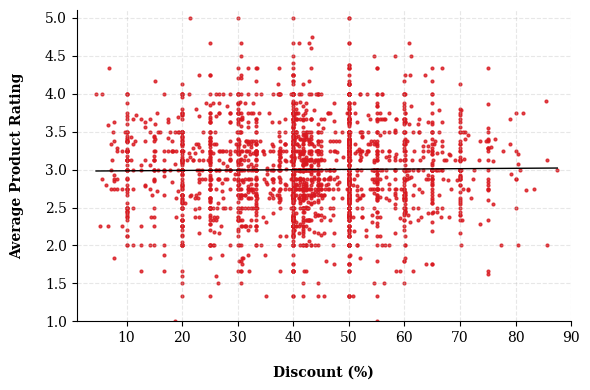

In [53]:
#fig specs
plt.figure(figsize = (6,4))#, dpi = 300)

#plotting data, regplot() will add regression line
ax = sns.regplot(
    data=plot_discount,
    x='discount_percentage',
    y='average_product_rating',
    color = penney_red,
    scatter_kws={'s': 4}, 
    ci = None,
    line_kws={'color': 'black','linestyle': '-', 'linewidth': 1}
)


#remove right and top axes borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#plt.title('average product rating vs. discount %')
plt.xlabel('Discount (%)', fontweight = 'bold', labelpad = 15)
ax.set_xlim(1, 90)
plt.ylabel('Average Product Rating', fontweight = 'bold',labelpad = 15)
ax.set_ylim(1, 5.1)

plt.grid(linestyle = '--', alpha = 0.3)
plt.tight_layout()
#plt.savefig('Scatter_avpr_discount.png', transparent = True)
plt.show()

Since we cannot fully trust the visuals, we will employ statistics (linear regression) to determine if there is a linear relationship between variables using pearsons correlation and calculate the p-value.

**Null hypothesis:** No linear relationship between discount % and average product rating 

**Alternative hypothesis:** linear relation does exist between discount % and average product rating

In [54]:
x = plot_discount['discount_percentage']
y = plot_discount['average_product_rating']

# Calculate sample correlation (r) and p-value for figure 6
correlation, p_value = pearsonr(x, y)

print(f"Pearson Correlation (r): {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson Correlation (r): 0.012
P-value: 0.526


There is no statistically significant relationship between Discount Percentage and Average Product Rating. i.e. P-value > 0.05

The data shows these two factors operate independently of one another. Therefore, we can conclude that the relationship is not real or statistically insignificant.